### Import Necessary Libraries

- PyTorch and torchvision for deep learning functionalities.
- Numpy for numerical computations.
- Matplotlib for data visualization.
- OpenCV (cv2) for image processing.
- Other modules for metrics computation and data handling.

In [1]:
# Import necessary libraries
import torch
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import random
import cv2
from torch.optim.lr_scheduler import ReduceLROnPlateau


Sets the device for computation (GPU if available, otherwise CPU), retrieves the current working directory, and defines paths to dataset directories relative to the current working directory. Additionally, defines the batch size for DataLoader.


In [2]:
# Set device for computation (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get current working directory
cwd = os.getcwd()

# Define paths to dataset directories relative to current working directory
data_dir = os.path.join(cwd, "chest_xray")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define batch size for DataLoader
batch_size = 32

Define transformations for training, validation, and test sets:
- For training set: resize images to (224, 224), apply random horizontal flip, convert to tensor, and normalize using mean and standard deviation.
- For validation and test sets: resize images to (224, 224), convert to tensor, and normalize using mean and standard deviation.

Create a custom dataset class `ChestXrayDataset` to load and preprocess the Chest X-ray images dataset:
- Initialize with dataset directory and optional transformation.
- Extract class labels and image paths.
- Implement methods to get the length of the dataset and retrieve a sample.


In [3]:
# Define transformations for training, validation, and test sets
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class ChestXrayDataset(torch.utils.data.Dataset):
    """
    Custom dataset class to load and preprocess the Chest X-ray images dataset.
    
    Args:
        data_dir (str): Path to the dataset directory.
        transform (callable, optional): Optional transform to be applied on a sample.
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.image_paths = []
        for cls in self.classes:
            cls_dir = os.path.join(data_dir, cls)
            cls_images = [os.path.join(cls_dir, img) for img in os.listdir(cls_dir) if img.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
            self.image_paths.extend(cls_images)
        # Extract class labels from parent directory name
        self.targets = [self.classes.index(os.path.basename(os.path.dirname(img_path))) for img_path in self.image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        
        Args:
            idx (int): Index of the sample to retrieve.
        
        Returns:
            tuple: Tuple containing the image and its target class.
        """
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        target = self.targets[idx]
        return img, target





Create datasets and dataloaders:
- Create datasets for training, validation, and testing using the `ChestXrayDataset` class with specified transformations.
- Use DataLoader to create data loaders for each dataset with the specified batch size.
- For the training dataset, enable shuffling to ensure randomness during training.


In [4]:
# Create datasets and dataloaders
train_dataset = ChestXrayDataset(train_dir, transform=train_transform)
val_dataset = ChestXrayDataset(val_dir, transform=val_transform)
test_dataset = ChestXrayDataset(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Initialize counts for normal and pneumonia images:
- Initialize variables `num_normal` and `num_pneumonia` to count the number of normal and pneumonia images, respectively.
- Iterate through the training dataset and increment the counts based on the labels.
- Print the total number of normal and pneumonia images.


In [5]:
# Initialize counts for normal and pneumonia images
num_normal = 0
num_pneumonia = 0

# Iterate through the dataset
for _, label in train_dataset:
    if label == 0:  # Assuming class 0 represents normal images
        num_normal += 1
    elif label == 1:  # Assuming class 1 represents pneumonia images
        num_pneumonia += 1

# Print the total number of normal and pneumonia images
print("Total number of normal images:", num_normal)
print("Total number of pneumonia images:", num_pneumonia)


Total number of normal images: 1341
Total number of pneumonia images: 3875


Visualize a batch of images with class labels:
- Define a function `imshow` to display a batch of images.
- Define a function `imshow_with_labels` to display a batch of images along with their corresponding class labels.
- Get a batch of training data using the `next(iter(train_loader))` function.
- Visualize the batch of images using `imshow_with_labels` function.


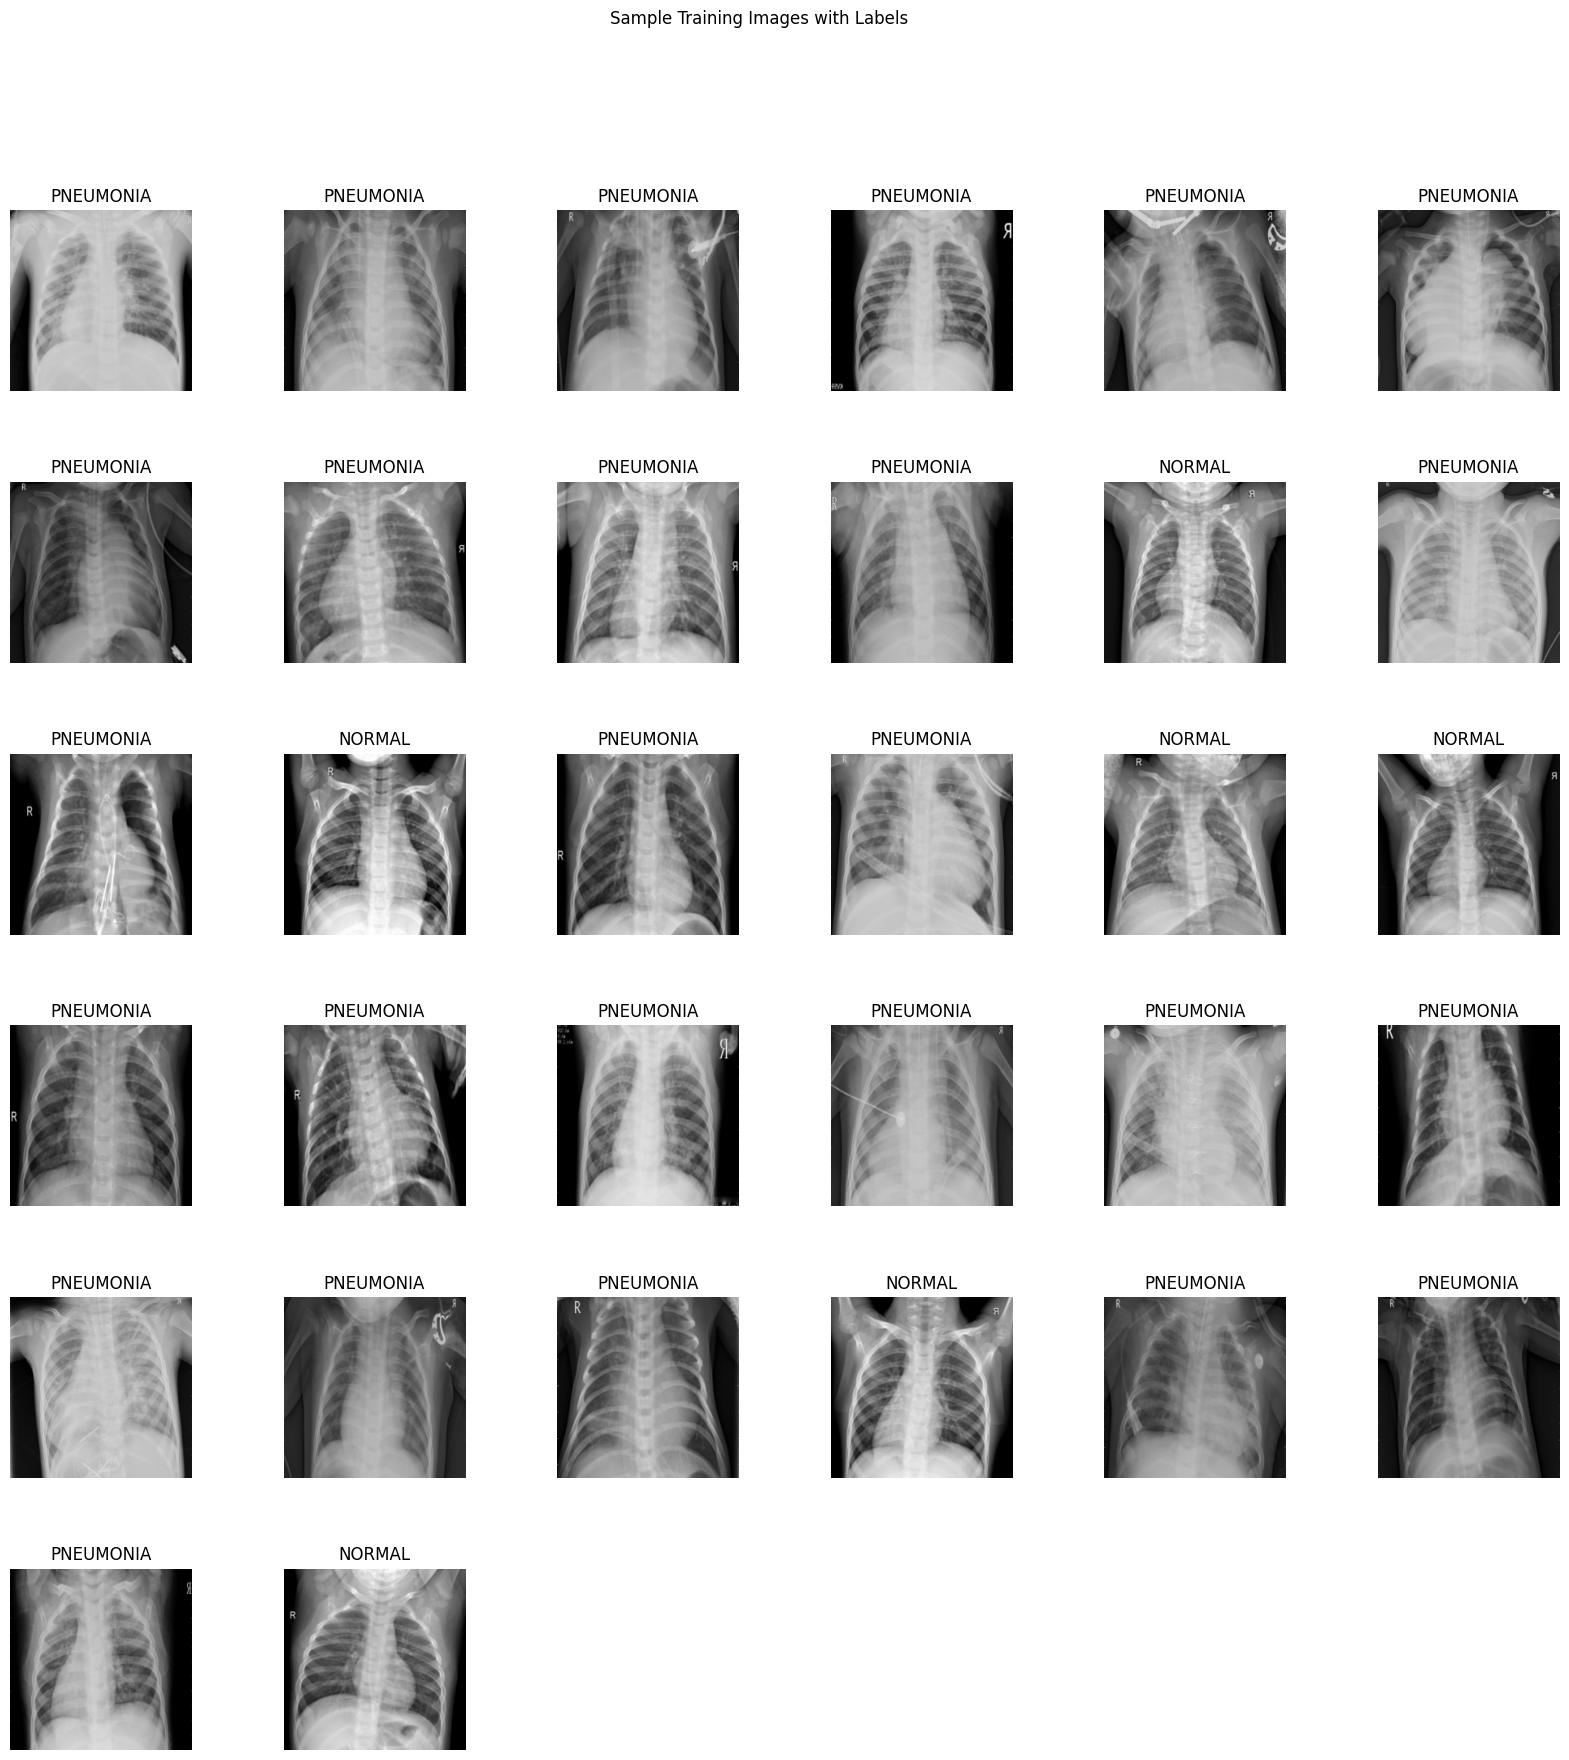

In [6]:
# Sanity check - visualize a batch of images
def imshow(inp, title=None):
    """Show a batch of images."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(50, 50)) 
    plt.imshow(inp)
    plt.axis('off')  # Turn off axis
    if title is not None:
        plt.title(title)
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch and visualize with class labels
def imshow_with_labels(inp, classes, title=None):
    """Show a batch of images along with their class labels."""
    num_images = min(inp.size(0), 36)  # Ensure a maximum of 36 images are displayed
    fig, axes = plt.subplots(6, 6, figsize=(20, 20))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    for i, ax in enumerate(axes.flat):
        if i < num_images:
            img = inp[i].numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            ax.imshow(img)
            ax.set_title(train_dataset.classes[classes[i]])
            ax.axis('off')
        else:
            ax.axis('off')  # Hide axes for empty subplots
    if title is not None:
        plt.suptitle(title)
    plt.show()

# Visualize the batch of images along with class labels
imshow_with_labels(inputs, classes, title='Sample Training Images with Labels')

Calculate and visualize the sizes of each dataset:
- Calculate the sizes of the training, validation, and test datasets.
- Create a pie chart to represent the distribution of data among the datasets.
- Add annotations to display the sizes of each dataset within the pie chart.
- Save the pie chart as an image file named "pie_chart_of_data_distribution.png".


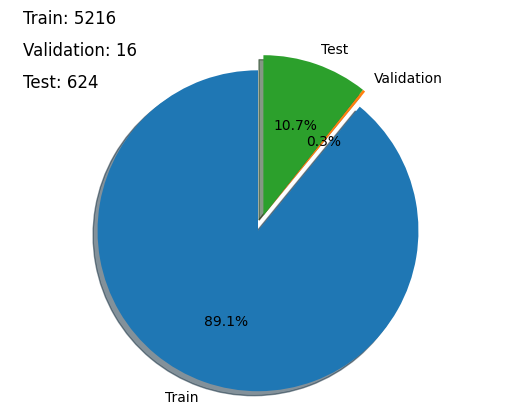

<Figure size 640x480 with 0 Axes>

In [7]:
# Calculate sizes of each dataset
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Train', 'Validation', 'Test'
sizes = [train_size, val_size, test_size]
explode = (0.1, 0, 0)  # only "explode" the 1st slice (i.e., 'Train')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add annotations to display the sizes
for i, size in enumerate(sizes):
    ax1.annotate(f'{labels[i]}: {size}', xy=(0, 0), xytext=(-1.5, 1.2 - i * 0.2), fontsize=12, color='black')

plt.show()
plt.savefig("pie_chart_of_data_distribution.png")


Load the pre-trained DenseNet121 model:
- Load the VGG-16 model architecture with pre-trained weights.
- Freeze the parameters of the model so they are not updated during training.
- Modify the fully connected layer to adapt it for binary classification with 2 classes.
- Move the model to the appropriate device (GPU if available, otherwise CPU).


In [8]:
# Load pre-trained DenseNet model
model = models.densenet121(pretrained=True)

# Freeze parameters
for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer for binary classification
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2)  # Output 2 classes: "Normal" and "Pneumonia"

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Define hyperparameters:
- Learning rate: 0.001
- Batch size: 32
- Number of epochs: 30

Define the optimizer:
- Adam optimizer with a learning rate of 0.001.

Print the modified VGG model architecture:
- Display the architecture of the modified VGG model with the updated fully connected layer.

Sanity check:
- Print the device on which the model is currently being used (GPU or CPU).


In [9]:
# Define hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 30

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print the modified DenseNet model architecture
print(model)

# Sanity check to see if the model is moved to the correct device
print(f"Model is using {device}")

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

- Calculate the size of the validation subset by taking 20% of the original training dataset size.
- Shuffle the indices of the training dataset.
- Extract a subset of the training dataset for validation using the shuffled indices.
- Create datasets and dataloaders for the validation subset and the remaining training dataset.
- Append the subset of training data to the validation dataset.
- Remove the subset data from the original training dataset.
- Create data loaders for the updated training and validation datasets.
- Print the sizes of the updated training and validation datasets for a sanity check.


In [10]:

validation_subset_size = int(len(train_dataset) * 0.1)  

# Shuffle the indices of the training dataset
indices = list(range(len(train_dataset)))
random.shuffle(indices)

# Extract a subset of the training dataset for validation
validation_indices = indices[:validation_subset_size]
remaining_indices = indices[validation_subset_size:]

# Create datasets and dataloaders
val_subset_dataset = torch.utils.data.Subset(train_dataset, validation_indices)
train_subset_dataset = torch.utils.data.Subset(train_dataset, remaining_indices)

# Append the subset of training data to the validation dataset
val_dataset += val_subset_dataset

# Remove the subset data from the original training dataset
train_dataset = train_subset_dataset

# Create data loaders for the updated datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# Sanity check: Print the sizes of the training and validation datasets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

Training dataset size: 4695
Validation dataset size: 537


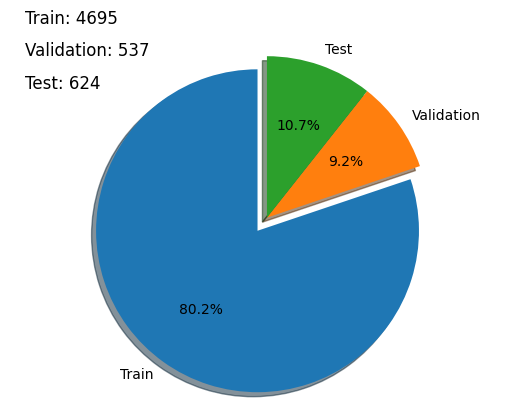

<Figure size 640x480 with 0 Axes>

In [11]:
# Calculate sizes of each dataset
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Train', 'Validation', 'Test'
sizes = [train_size, val_size, test_size]
explode = (0.1, 0, 0)  # only "explode" the 1st slice (i.e., 'Train')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add annotations to display the sizes
for i, size in enumerate(sizes):
    ax1.annotate(f'{labels[i]}: {size}', xy=(0, 0), xytext=(-1.5, 1.2 - i * 0.2), fontsize=12, color='black')

plt.show()
plt.savefig("pie_chart_of_increased_validationTest_from_trainSet.png")

## Model Training 

- Initialize variables to track the best validation loss and the corresponding epoch.
- Define the number of epochs to wait if validation loss doesn't improve, along with a counter to track epochs with no improvement.
- Initialize lists to store training and validation loss, as well as accuracy.
- Define the learning rate scheduler and the criterion for calculating loss.
- Run the training loop for the specified number of epochs.
- During each epoch, perform training and validation phases.
- Calculate training and validation loss and accuracy.
- Step the learning rate scheduler.
- Print the progress of each epoch including training loss, training accuracy, validation loss, validation accuracy, and learning rate.
- Store the values for plotting.
- Check if validation loss improved and update the best validation loss and epoch accordingly.
- Check for early stopping if there is no improvement in validation loss for a specified number of epochs.
- Print the best validation loss and corresponding epoch.


In [12]:
# Initialize variables for tracking best validation loss and corresponding epoch
best_val_loss = float('inf')
best_epoch = 0

# Define the number of epochs to wait if validation loss doesn't improve
patience = 5
counter = 0  # Counter to track the number of epochs with no improvement

# Initialize lists to store training and validation loss, and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    # Calculate training loss and accuracy
    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    # Calculate validation loss and accuracy
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update the learning rate scheduler
    scheduler.step(val_loss)

    # Print the training progress
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
            break

# Print the best validation loss and corresponding epoch
print(f'Best validation loss: {best_val_loss:.4f} at epoch {best_epoch+1}')

/usr/local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/30], Train Loss: 0.2866, Train Acc: 0.8880, Val Loss: 0.1806, Val Acc: 0.9404
Epoch [2/30], Train Loss: 0.1731, Train Acc: 0.9361, Val Loss: 0.1477, Val Acc: 0.9441
Epoch [3/30], Train Loss: 0.1495, Train Acc: 0.9423, Val Loss: 0.1516, Val Acc: 0.9423
Epoch [4/30], Train Loss: 0.1524, Train Acc: 0.9419, Val Loss: 0.1385, Val Acc: 0.9497
Epoch [5/30], Train Loss: 0.1307, Train Acc: 0.9517, Val Loss: 0.1213, Val Acc: 0.9460
Epoch [6/30], Train Loss: 0.1184, Train Acc: 0.9525, Val Loss: 0.1169, Val Acc: 0.9534
Epoch [7/30], Train Loss: 0.1176, Train Acc: 0.9578, Val Loss: 0.1236, Val Acc: 0.9479
Epoch [8/30], Train Loss: 0.1247, Train Acc: 0.9523, Val Loss: 0.1042, Val Acc: 0.9590
Epoch [9/30], Train Loss: 0.1113, Train Acc: 0.9610, Val Loss: 0.1072, Val Acc: 0.9534
Epoch [10/30], Train Loss: 0.1177, Train Acc: 0.9542, Val Loss: 0.1228, Val Acc: 0.9497
Epoch [11/30], Train Loss: 0.1083, Train Acc: 0.9612, Val Loss: 0.1315, Val Acc: 0.9385
Epoch [12/30], Train Loss: 0.1073, Train 

## Plotting Training and Validation Metrics

### Training and Validation Loss

- Create a figure to plot the training and validation loss.
- Plot the training loss and validation loss over epochs.
- Set titles and labels for the axes.
- Add a legend to differentiate between training and validation loss.
- Display the plot.

### Training and Validation Accuracy

- Create a figure to plot the training and validation accuracy.
- Plot the training accuracy and validation accuracy over epochs.
- Set titles and labels for the axes.
- Add a legend to differentiate between training and validation accuracy.
- Display the plot.


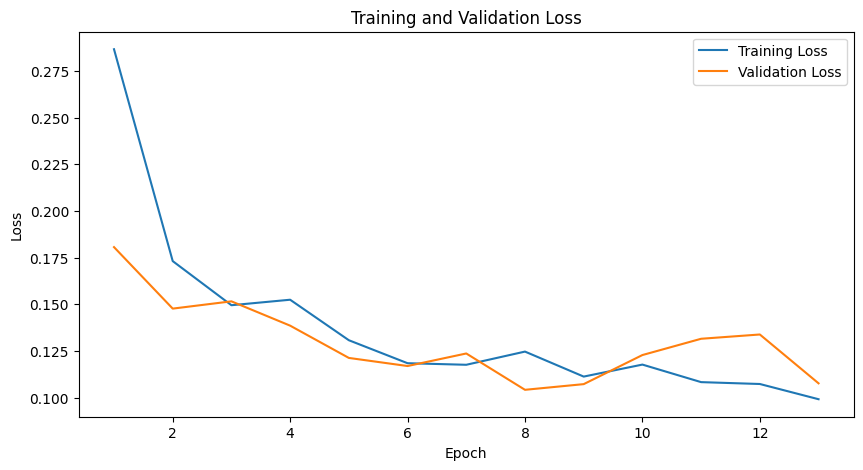

<Figure size 640x480 with 0 Axes>

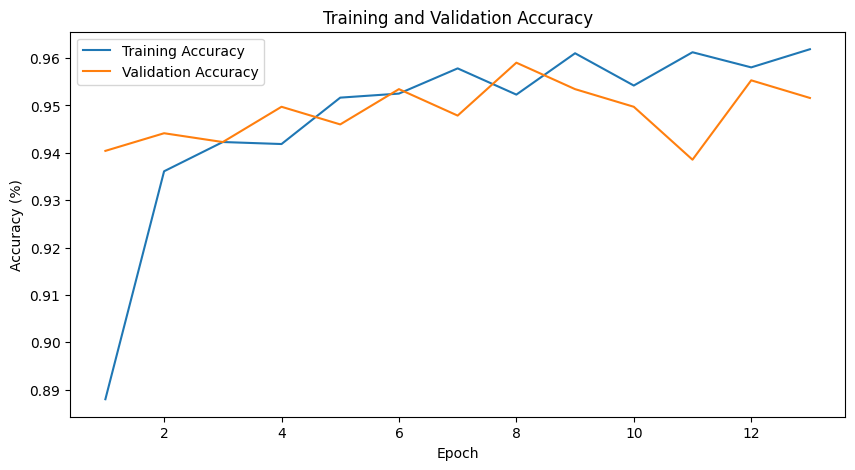

<Figure size 640x480 with 0 Axes>

In [13]:

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig("Training_and_Validation_Loss.png")

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
plt.savefig("Training_and_Validation_Accuracy.png")

## Evaluate Model and Plot Confusion Matrix

### Function Description:

The `evaluate_model` function evaluates the trained model on the specified data loader and plots the confusion matrix.

- **Arguments:**
  - `loader (DataLoader)`: DataLoader containing the dataset to evaluate.
  - `name (str)`: Name of the subset (e.g., "Train", "Validate").

- **Returns:**
  - None

### Evaluation Process:

- Set the model to evaluation mode.
- Iterate through the data loader to obtain model predictions and ground truths.
- Calculate evaluation metrics such as accuracy, precision, recall, and F1 score.
- Generate and plot the confusion matrix.
- Print evaluation metrics and the classification report.

### Evaluation on Train and Validate Subsets:

- Evaluate the model on the training and validation subsets using the `evaluate_model` function.
- Display the confusion matrix and metrics for each subset.


/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


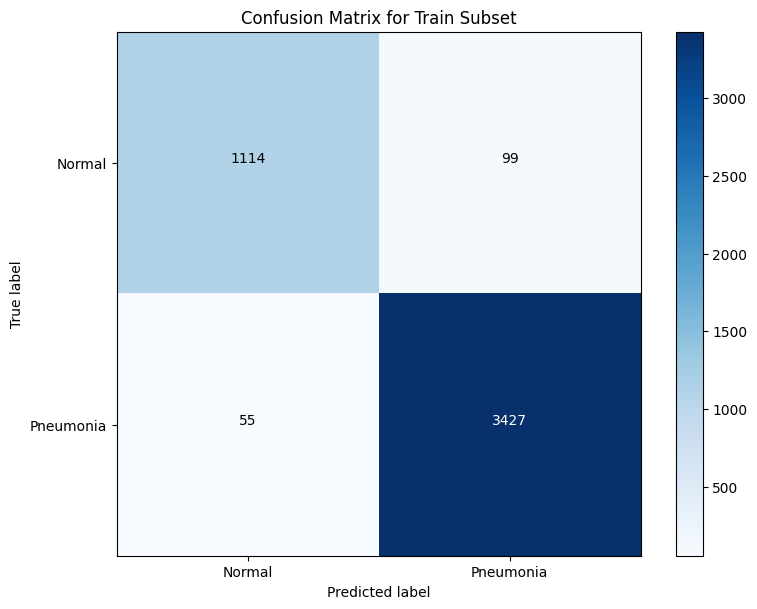

Metrics for Train subset:
Accuracy: 0.9672
Precision: 0.9719
Recall: 0.9842
F1 Score: 0.9780
Confusion Matrix:
[[1114   99]
 [  55 3427]]

Classification Report for Train subset:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1213
           1       0.97      0.98      0.98      3482

    accuracy                           0.97      4695
   macro avg       0.96      0.95      0.96      4695
weighted avg       0.97      0.97      0.97      4695




/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


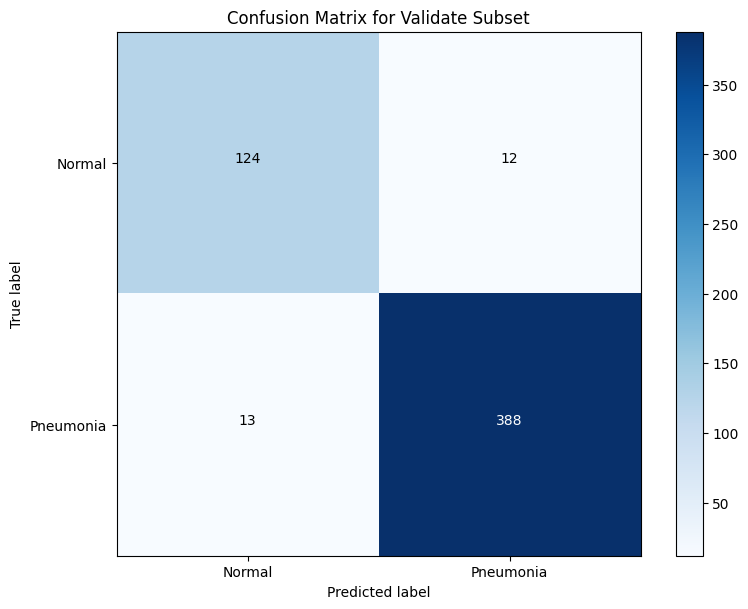

Metrics for Validate subset:
Accuracy: 0.9534
Precision: 0.9700
Recall: 0.9676
F1 Score: 0.9688
Confusion Matrix:
[[124  12]
 [ 13 388]]

Classification Report for Validate subset:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       136
           1       0.97      0.97      0.97       401

    accuracy                           0.95       537
   macro avg       0.94      0.94      0.94       537
weighted avg       0.95      0.95      0.95       537




In [14]:
def evaluate_best_model(loader, name, best_model_path):
    """
    Evaluate the best model on the specified data loader and plot the confusion matrix.

    Args:
        loader (DataLoader): DataLoader containing the dataset to evaluate.
        name (str): Name of the subset (e.g., "Train", "Validate").
        best_model_path (str): Path to the saved best model.

    Returns:
        None
    """
    # Load the best model
    model = models.densenet121(pretrained=False)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, 2)  # Output 2 classes: "Normal" and "Pneumonia"
    model.load_state_dict(torch.load(best_model_path))
    model = model.to(device)
    model.eval()

    predictions = []
    ground_truths = []
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(targets.cpu().numpy())

    accuracy = accuracy_score(ground_truths, predictions)
    precision = precision_score(ground_truths, predictions)
    recall = recall_score(ground_truths, predictions)
    f1 = f1_score(ground_truths, predictions)
    
    # Generate confusion matrix
    cm = confusion_matrix(ground_truths, predictions)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name} Subset')
    plt.colorbar()
    classes = ["Normal", "Pneumonia"]  
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(f"Metrics for {name} subset:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    # Generate classification report
    report = classification_report(ground_truths, predictions)
    print(f"Classification Report for {name} subset:\n{report}\n")

# Path to the saved best model
best_model_path = 'best_model.pth'

# Evaluate the best model on train subset
evaluate_best_model(train_loader, "Train", best_model_path)

# Evaluate the best model on validate subset
evaluate_best_model(val_loader, "Validate", best_model_path)

## Evaluate Model on Test Set and Plot Confusion Matrix

### Function Description:

The `evaluate_model_test` function evaluates the trained model on the specified data loader (test set), stores true labels, predicted labels, and input images for visualization, and plots the confusion matrix.

- **Arguments:**
  - `loader (DataLoader)`: DataLoader containing the test dataset to evaluate.
  - `name (str)`: Name of the subset (e.g., "Test").

- **Returns:**
  - `true_labels (list)`: True labels.
  - `pred_labels (list)`: Predicted labels.
  - `input_images (list)`: Input images for visualization.
  - `accuracy (float)`: Accuracy.
  - `precision (float)`: Precision.
  - `recall (float)`: Recall.
  - `f1 (float)`: F1 Score.
  - `confusion_matrix (array)`: Confusion matrix.

### Evaluation Process:

- Set the model to evaluation mode.
- Iterate through the test data loader to obtain model predictions, true labels, and input images.
- Calculate evaluation metrics such as accuracy, precision, recall, and F1 score.
- Generate and plot the confusion matrix with labels.
- Print evaluation metrics and the classification report.
- Return the true labels, predicted labels, input images, accuracy, precision, recall, F1 score, and confusion matrix.

### Evaluation on Test Subset:

- Evaluate the model on the test subset using the `evaluate_model_test` function.
- Display the confusion matrix and metrics for the test subset.
- Print the total correct predictions and the total number of test images.


/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


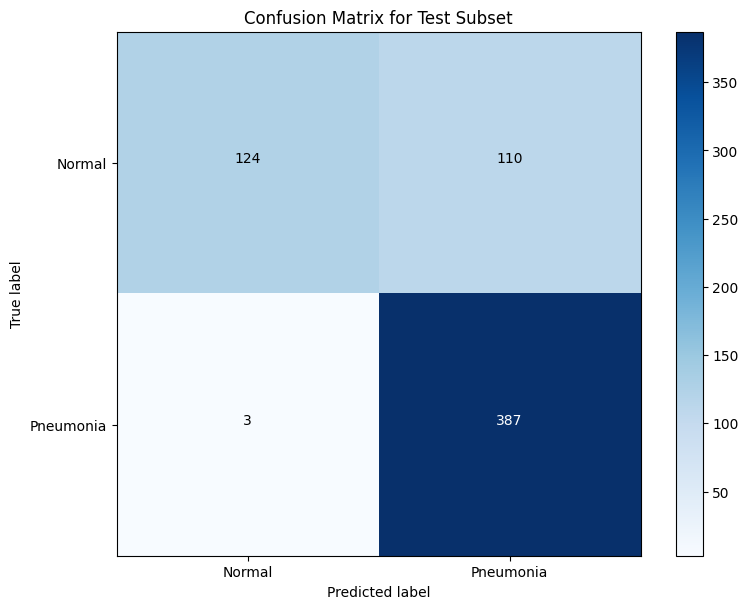

Metrics for Test subset:
Accuracy: 0.8189
Precision: 0.7787
Recall: 0.9923
F1 Score: 0.8726
Confusion Matrix:
[[124 110]
 [  3 387]]

Classification Report for Test subset:
              precision    recall  f1-score   support

      Normal       0.98      0.53      0.69       234
   Pneumonia       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624


Total Correct: 511.0 
Total Test Images: 624.0


In [25]:
def evaluate_model_test(loader, name, best_model_path):
    """
    Evaluate the trained model on the specified data loader (test set), store true labels, predicted labels, and input images for visualization, and plot the confusion matrix.

    Args:
        loader (DataLoader): DataLoader containing the test dataset to evaluate.
        name (str): Name of the subset (e.g., "Test").
        best_model_path (str): Path to the saved best model.

    Returns:
        true_labels (list): True labels.
        pred_labels (list): Predicted labels.
        input_images (list): Input images for visualization.
        accuracy (float): Accuracy.
        precision (float): Precision.
        recall (float): Recall.
        f1 (float): F1 Score.
        confusion_matrix (array): Confusion matrix.
    """
    # Load the best model
    model = models.densenet121(pretrained=False)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, 2)  # Output 2 classes: "Normal" and "Pneumonia"
    model.load_state_dict(torch.load(best_model_path))
    model = model.to(device)
    model.eval()

    predictions = []
    ground_truths = []
    input_images = []
    running_correct = 0.0
    running_total = 0.0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            predictions.extend(predicted.cpu().numpy())
            ground_truths.extend(targets.cpu().numpy())
            input_images.extend(inputs.cpu().numpy())

            # Update running correct and total
            running_total += targets.size(0)
            running_correct += predicted.eq(targets).sum().item()

    accuracy = accuracy_score(ground_truths, predictions)
    precision = precision_score(ground_truths, predictions)
    recall = recall_score(ground_truths, predictions)
    f1 = f1_score(ground_truths, predictions)
    
    # Generate confusion matrix
    cm = confusion_matrix(ground_truths, predictions)
    
    # Plot confusion matrix with labels
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {name} Subset')
    plt.colorbar()
    classes = ["Normal", "Pneumonia"]  
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    print(f"Metrics for {name} subset:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}\n")

    # Generate classification report
    report = classification_report(ground_truths, predictions, target_names=classes)
    print(f"Classification Report for {name} subset:\n{report}\n")

    print("Total Correct: {} \nTotal Test Images: {}".format(running_correct, running_total))

    return ground_truths, predictions, input_images, accuracy, precision, recall, f1, cm

# Path to the saved best model
best_model_path = 'best_model.pth'

# Call the function and store the returned values
true_labels, pred_labels, input_images, accuracy, precision, recall, f1, cm = evaluate_model_test(test_loader, "Test", best_model_path)


## Visualize Test Images with Predicted and True Labels

### Process:

- Shuffle the indices of the input images to randomize the order for visualization.
- Define the class names for labeling the images.
- Visualize a grid of test images along with their predicted and true labels.
- Each subplot in the grid displays an image with its predicted and true labels.
- The title of each subplot includes the predicted label and the actual label.
- If the prediction is correct, the title is displayed in green; otherwise, it's displayed in red.
- Hide the axes for better visualization.

### Sample Visualization:

- Below is a 4x4 grid of test images with their predicted and true labels.
- Each image is labeled with its predicted class and the actual class.
- The title color indicates whether the prediction is correct or not.


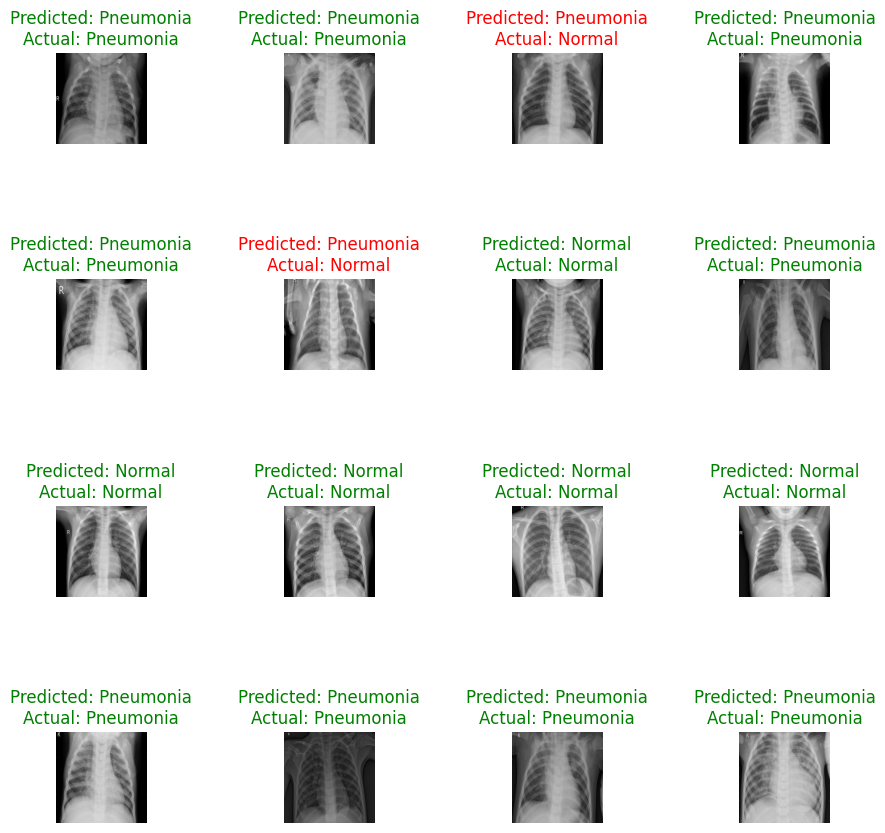

In [24]:
# Shuffle indices
indices = list(range(len(input_images)))
random.shuffle(indices)

# Define the class names
class_names = ['Normal', 'Pneumonia']

# Visualize the images along with predicted and true labels
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.subplots_adjust(hspace=1.5, wspace=1.5)
x = 0
for i in range(4):
    for j in range(4):
        # Get the image and labels using shuffled indices
        index = indices[x]
        inp = input_images[index].squeeze()
        true_label = true_labels[index]
        pred_label = pred_labels[index]

        # Normalize the image for display
        inp = inp.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Display the image
        axes[i, j].imshow(inp)

        # Set the title with the predicted and actual labels
        title = "Predicted: {}\nActual: {}".format(class_names[pred_label], class_names[true_label])
        color = 'green' if pred_label == true_label else 'red'
        axes[i, j].set_title(title, color=color)

        # Hide the axes
        axes[i, j].axis('off')

        # Move to the next image
        x += 1

plt.show()


## Save Trained Model

### Process:

- Define a directory to save the trained model. If the directory doesn't exist, create it.
- Specify the path for saving the model including the directory and the filename.
- Save the state dictionary of the trained model to the specified path using `torch.save()` function.




In [17]:

#  save the model 
save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)  # Create the directory 
model_path = os.path.join(save_dir, 'trained_model.pth')
torch.save(model.state_dict(), model_path)


This function creates a video displaying a fly-through of input images in reverse order, annotating each frame with predicted and true labels. Here's a concise breakdown:

- **Inputs**: 
  - `input_images`: List of input images.
  - `true_labels`: True labels corresponding to the input images.
  - `pred_labels`: Predicted labels corresponding to the input images.
  - `class_names`: List of class names.
  - `output_video_path`: Path to save the output video.
  - `fps` (optional): Frames per second for the output video. Default is 1.
  - `frame_size` (optional): Size of each frame (width, height). Default is (512, 512).

- **Processing**:
  - It iterates through the input images in reverse order.
  - For each image, it normalizes the image for display and resizes it to the specified frame size.
  - Text annotations are added to indicate the predicted and true labels.
  - The text color is determined based on prediction correctness.
  - Frames are written to the output video using OpenCV.
  
- **Output**:
  - The generated video file showing the fly-through of input images with annotations for predicted and true labels.

This function offers a convenient way to visualize the model's predictions on input images in reverse order.

In [18]:
def create_fly_through_video_reverse(input_images, true_labels, pred_labels, class_names, output_video_path, fps=1, frame_size=(512, 512)):
    """
    Create a fly-through video showing the predicted and true labels for each image in reverse order.

    Args:
        input_images (list): List of input images.
        true_labels (list): True labels corresponding to input images.
        pred_labels (list): Predicted labels corresponding to input images.
        class_names (list): List of class names.
        output_video_path (str): Path to save the output video.
        fps (int, optional): Frames per second for the output video. Defaults to 1.
        frame_size (tuple, optional): Frame size (width, height) for the output video. Defaults to (512, 512).
    """
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4 format
    out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

    # Create a fly-through video in reverse order
    for i in range(len(input_images) - 1, -1, -1):
        inp = input_images[i].squeeze()
        true_label = true_labels[i]
        pred_label = pred_labels[i]

        # Normalize the image for display
        inp = inp.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

        # Scale image to the desired size
        inp_resized = cv2.resize(inp, frame_size)

        # Set the title with the predicted and actual labels
        pred_text = "Predicted: {}".format(class_names[pred_label])
        true_text = "Actual: {}".format(class_names[true_label])

        # Define text color based on prediction correctness
        color = (0, 255, 0) if pred_label == true_label else (0, 0, 255)

        # Calculate the text position for center alignment
        pred_text_width = cv2.getTextSize(pred_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0][0]
        true_text_width = cv2.getTextSize(true_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0][0]
        pred_text_x = int((frame_size[0] - pred_text_width) / 2)
        true_text_x = int((frame_size[0] - true_text_width) / 2)

        # Write text on the frame with drastically reduced font size
        cv2.putText(inp_resized, pred_text, (pred_text_x, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
        cv2.putText(inp_resized, true_text, (true_text_x, 90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        # Convert image to uint8 for writing to video
        inp_resized = (inp_resized * 255).astype(np.uint8)

        # Write frame to video
        out.write(inp_resized)

    # Release video writer
    out.release()


create_fly_through_video_reverse(input_images, true_labels, pred_labels, class_names, "fly_through_video_reverse.mp4")
